# 안개 발생 진단 분류 모델 데이터셋 EDA

## 1. 데이터 설명

- 컬럼

   
    - `stn_id` : 지점 번호
    - `ws10_deg` : 10분 평균 풍향, 단위: deg
    - `ws10_ms` : 10분 평균 풍속, 단위: m/s
    - `ta` : 1분 평균 기온 10분 주기, 단위: C
    - `re` : 강수 유무 (0:무강수, 1:강수)
    - `hm` : 1분 평균 상대 습도 10분 주기, 단위: %
    - `sun10` : 1분 일사량 10분단위 합계, 단위: MJ
    - `ts` : 1분 평균 지면온도 10분 주기, 단위: C
    - `class` : 시정 구간

- 시정 계급 기준 (비고: 안개의 기준)

    - `1` : 0 < 시정 < 200
    - `2` : 200 <= 시정 < 500
    - `3` : 500 <= 시정 < 1000
    - `4` : 1000 <= 시정


## 2. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import rcParams


import os
import pickle

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option("float_format", "{:.4f}".format)

In [2]:
# # colab 나눔 폰트 설치
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

### 2-1 로컬 디렉토리 경로

In [4]:
# 작업 디렉토리 변경 (로컬 디렉토리에서 작업시 실행)

def get_local_path(train_dataset_name, test_dataset_name):

    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 상위 디렉토리에 fog_data가 없다면 fog_data 폴더 생성
    # (이미 폴더 있어도 exist_ok=True면 넘어감)
    os.makedirs("fog_data", exist_ok=True)

    # train/test 데이터셋 경로 잡아준다
    train_path = os.path.join(os.getcwd(), "fog_data", train_dataset_name)
    test_path = os.path.join(os.getcwd(), "fog_data", test_dataset_name)

    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        train_path = train_path.replace("\\", "/")
        test_path = test_path.replace("\\", "/")

    # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return train_path, test_path

In [5]:
train_path, test_path = get_local_path("fog_train.csv", "fog_test.csv")

### 2-2. colab 디렉토리 경로 (colab 작업시)

In [6]:
# # 구글 드라이브 파일 접근
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# # colab 파일 경로 생성 함수
# # colab에서 작업시 주석 풀고 실행

# def get_colab_path(train_dataset_name, test_dataset_name):

#     fog_folder = "drive/MyDrive/weather_bigdata/fog_data"
#     os.makedirs(fog_folder, exist_ok=True)

#     # train/test 데이터셋 경로 잡아준다
#     train_path = os.path.join(os.getcwd(), fog_folder, train_dataset_name)
#     test_path = os.path.join(os.getcwd(), fog_folder, test_dataset_name)

#     return train_path, test_path

In [8]:
# train_path, test_path = get_colab_path("fog_train_modified.csv", "fog_test_modified.csv")

In [9]:
# print(train_path)
# print(test_path)

## 3. 데이터셋 로드

In [10]:
# 데이터셋 불러오기
# train_df = pd.read_csv(train_path)
# test_df = pd.read_csv(test_path)

In [11]:
fog_train_df = pd.read_csv(train_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)
fog_test_df = pd.read_csv(test_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)

### 3-1. 결측치 치환 함수

In [12]:
# -99, -99.9인 데이터를 np.nan으로 치환하는 함수

def switch_to_nan(train_df, test_df):
    
    train_df = train_df.replace({-99:np.nan, -99.9:np.nan})
    test_df = test_df.replace({-99:np.nan, -99.9:np.nan})
    
    return train_df, test_df

In [13]:
train_df, test_df = switch_to_nan(fog_train_df, fog_test_df)

### 3-2. 컬럼 수정 및 제거 함수

In [14]:
# 컬럼 수정 및 제거 함수
def modify_columns(train_df, test_df):

    # stn_id 수정 : A, B, C, D, E로 수정
    train_df["stn_id"] = train_df["stn_id"].apply(lambda x: x[0])
    test_df["stn_id"] = test_df["stn_id"].apply(lambda x: x[0])

    # year, month, day, time, minute, 컬럼 drop
    train_df.drop(columns=["year", "month", "day", "time", "minute", "vis1"], inplace=True)
    test_df.drop(columns=["year", "month", "day", "time", "minute"], inplace=True)

    # class 컬럼 순서형 변수로 변경
    train_df["class"] = train_df["class"].astype("int").astype("str")

    return train_df, test_df

In [15]:
# train_df, test_df = modify_columns(train_df, test_df)

### 3-3. 안개 여부 컬럼 생성 함수
- `class` = 4 : 안개 X (0)
- `class` <= 3 : 안개 O (1)

In [16]:
def is_fog(df, column):
    df["is_fog"] = df[column].apply(lambda x: 0 if x > 3 else 1)
    return df

In [17]:
train_df = is_fog(train_df, "class")

### 3-4. 결측치 처리 및 변수 변경 함수

In [18]:
def drop_and_ordinal(df, column):

    # 결측치 drop
    df.dropna(inplace=True)
    
    # class 컬럼 순서형 변수로 변경
    df[column] = df[column].astype("int").astype("str")
    
    return df

In [19]:
train_df = drop_and_ordinal(train_df, "class")

In [20]:
# class 컬럼 값 count
class_cnt = train_df["class"].value_counts().to_frame()

# class 컬럼 값 비율
class_pct = train_df["class"].value_counts(normalize=True).to_frame()

# 개수, 비율 concat
pd.concat([class_cnt, class_pct], axis=1).sort_index()

count  proportion
class                     
1         7806      0.0026
2        11975      0.0040
3        11940      0.0040
4      2963129      0.9894

In [21]:
# is_fog 컬럼 값 count
is_fog_cnt = train_df["is_fog"].value_counts().to_frame()

# is_fog 컬럼 값 비율
is_fog_pct = train_df["is_fog"].value_counts(normalize=True).to_frame()

# 개수, 비율 concat
pd.concat([is_fog_cnt, is_fog_pct], axis=1).sort_index()

count  proportion
is_fog                     
0       2963129      0.9894
1         31721      0.0106

### 3-5. 풍향

In [22]:
def cardinal_points(df, column):

    # 8방위 : 45도 경계선, 16방위 : 22.5도 경계선
    
    # # ws10_deg 컬럼을 16방위로 환산
    # cardinal_points = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", 
    #                "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]

    # val = int((num/45)+.5)
    val = df[column].apply(lambda x: int(x/45+.5))

    # ws10_deg 컬럼을 8방위로 환산
    direction_points = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
    
    # # 환산한 방위를 반영한 새로운 컬럼 생성
    # df["ws10_dir"] = pd.cut(df[column], bins=16, labels=cardinal_points)

    # 환산한 방위를 반영한 새로운 컬럼 생성
    df["ws10_dir"] = val.apply(lambda x: direction_points[(x % 8)])

    return df

In [23]:
train_df["ws10_deg"].apply(lambda x: int(x/45+.5))

0          0
1          0
2          0
3          1
4          1
          ..
3156454    7
3156455    7
3156456    6
3156457    6
3156458    6
Name: ws10_deg, Length: 2994850, dtype: int64

In [24]:
# def degToCompass(num):
#     # 8방위 : 45도 경계선, 16방위 : 22.5도 경계선
#     # val=int((num/22.5)+.5)
#     val = int((num/45)+.5)
#     # arr=["N","NNE","NE","ENE","E","ESE", "SE", "SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
#     arr = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
#     print(arr[(val % 8)])

In [25]:
# degToCompass(337.4)

In [26]:
train_df = cardinal_points(train_df, "ws10_deg")

In [27]:
# ws10_dir 컬럼 값 count
ws10_dir_cnt = train_df["ws10_dir"].value_counts().to_frame()

# ws10_dir 컬럼 값 비율
ws10_dir_pct = train_df["ws10_dir"].value_counts(normalize=True).to_frame()

direction_order = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]

# 개수, 비율 concat
direction_df = pd.concat([ws10_dir_cnt, ws10_dir_pct], axis=1).reindex(direction_order)
direction_df

count  proportion
ws10_dir                    
N         345280      0.1153
NE        414812      0.1385
E         302604      0.1010
SE        296970      0.0992
S         234878      0.0784
SW        430311      0.1437
W         549559      0.1835
NW        420436      0.1404

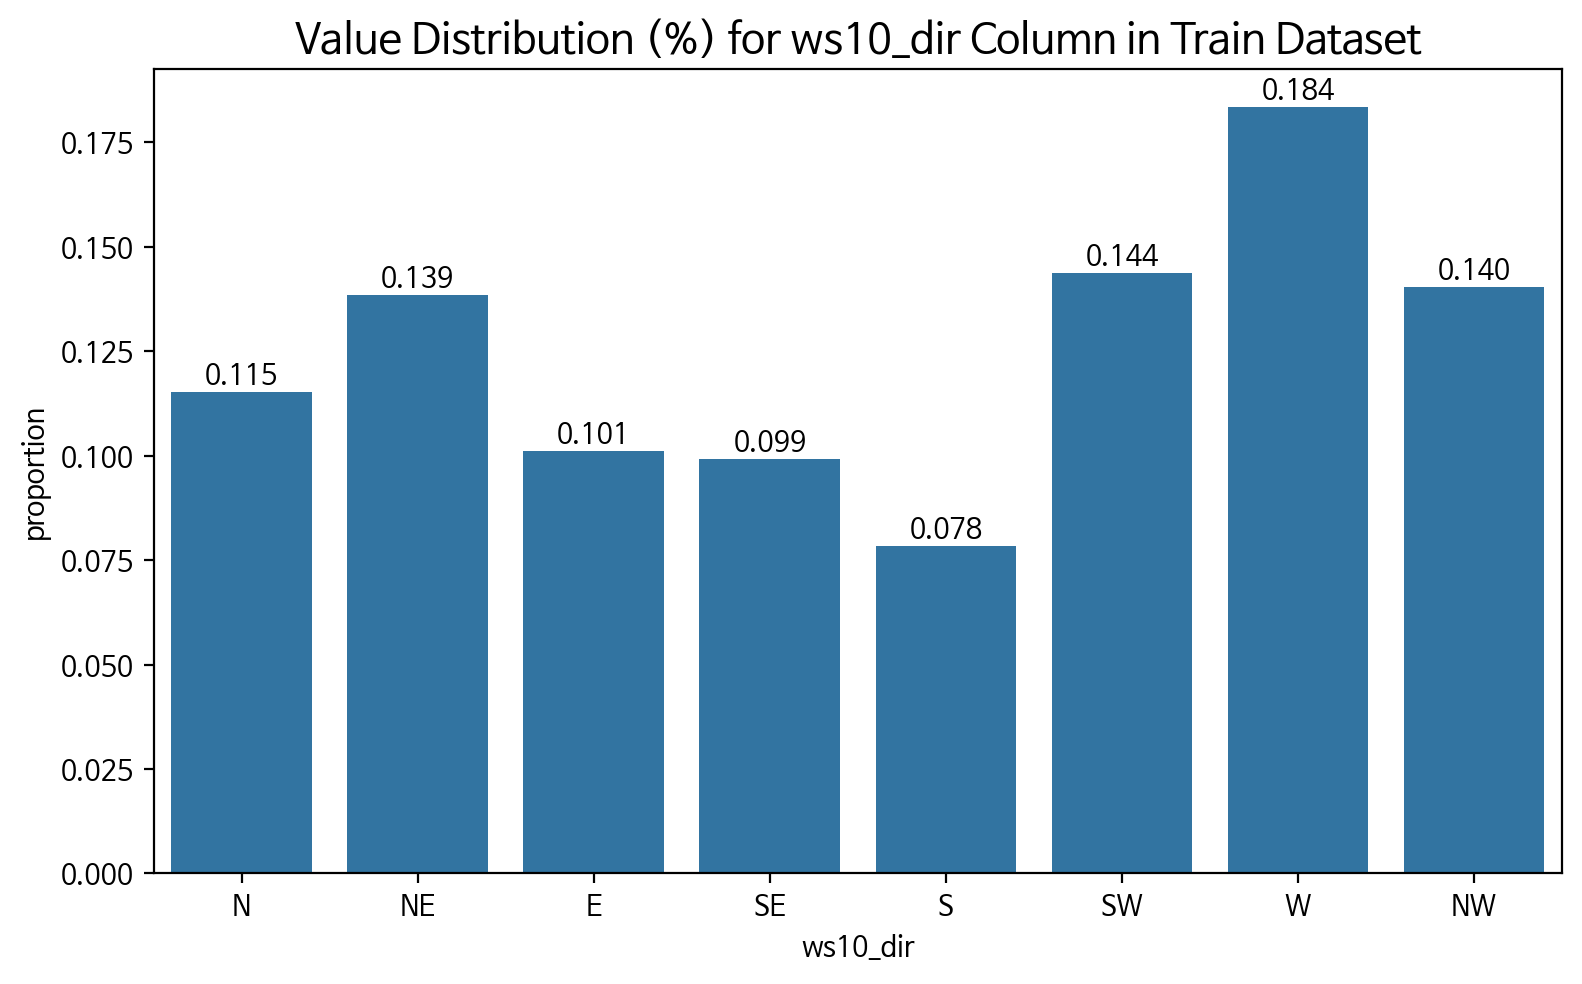

In [28]:
# 결측치 비율 시각화
plt.figure(figsize=(8, 5))
sns_pct = sns.barplot(x="ws10_dir", y="proportion", data=direction_df)
# sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                   # .get_height() : y좌표

    plt.text(bar.get_x() + bar.get_width()/2,   # 퍼센트 글자 위치
             height+0.002,                        # 퍼센트 글자 높이
             "%.3f" % height,                   # 퍼센트 소수점 지정
             ha="center")                       # 가운데 정렬

# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Value Distribution (%) for ws10_dir Column in Train Dataset", fontsize=15)
plt.tight_layout()
plt.show()

In [29]:
dir_by_fog = train_df.groupby('is_fog')['ws10_dir'].value_counts(normalize=True, sort=False).to_frame()
(np.round(dir_by_fog.unstack() * 100, 2).astype(str) + '%')

proportion                                                       
ws10_dir          E       N      NE      NW      S      SE      SW       W
is_fog                                                                    
0            10.07%  11.44%  13.89%  14.06%  7.83%   9.89%  14.38%  18.44%
1            13.31%  19.58%  10.57%  12.46%  8.75%  11.99%  13.47%   9.86%

In [30]:
np.round(dir_by_fog * 100, 2).sort_values(["is_fog", "proportion"], ascending=[False, False])

proportion
is_fog ws10_dir            
1      N            19.5800
       SW           13.4700
       E            13.3100
       NW           12.4600
       SE           11.9900
       NE           10.5700
       W             9.8600
       S             8.7500
0      W            18.4400
       SW           14.3800
       NW           14.0600
       NE           13.8900
       N            11.4400
       E            10.0700
       SE            9.8900
       S             7.8300

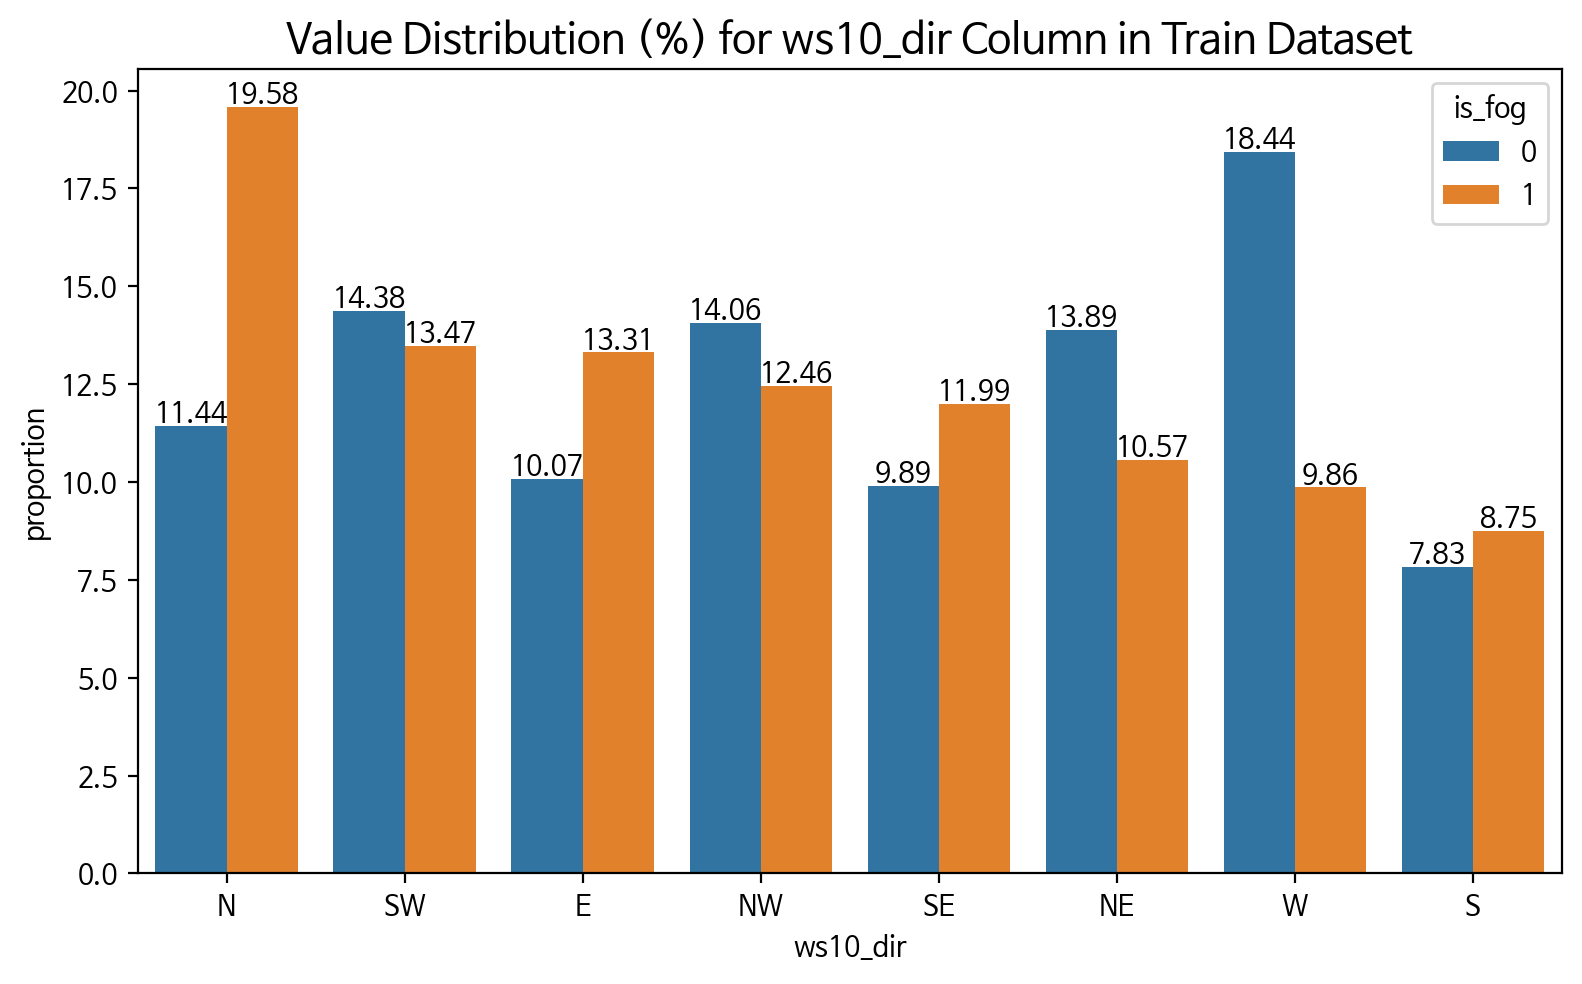

In [31]:
# 결측치 비율 시각화
plt.figure(figsize=(8, 5))

sns_pct = sns.barplot(x="ws10_dir", 
                      y="proportion", 
                      hue="is_fog", 
                      data=np.round(dir_by_fog * 100, 2).sort_values(["is_fog", "proportion"], ascending=[False, False]))


# sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                      # bar의 높이를 가져옴
    if height > 0:                                 # 높이가 0보다 클 때만 텍스트를 추가
        plt.text(bar.get_x() + bar.get_width()/2,  # 글자 위치 x좌표
                 height + 0.1,                   # 글자 위치 y좌표
                 "%.2f" % height,                  # 소수점 셋째 자리까지 비율 표시
                 ha="center")                      # 가운데 정렬


# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Value Distribution (%) for ws10_dir Column in Train Dataset", fontsize=15)
plt.tight_layout()
plt.show()

### 3-6. 계절별 비교

In [32]:
train_copy = train_df.copy()
# stn_id 수정 : A, B, C, D, E로 수정
train_copy["stn_id"] = train_copy["stn_id"].apply(lambda x: x[0])

In [45]:
def month_to_season(df, column):

    val = df[column].apply(lambda x: x%12 // 3)

    seasons = ["winter", "spring", "summer", "autumn"]
    # 구간에 따라 계절로 나눈다
    df["season"] = val.apply(lambda x: seasons[(x)])
    return df

In [46]:
train_copy = month_to_season(train_copy, "month")

In [47]:
train_copy["season"].value_counts()

season
spring    782943
summer    773889
autumn    757110
winter    680908
Name: count, dtype: int64

In [48]:
train_copy.head(3)

year  month  day  time  minute stn_id  ws10_deg  ws10_ms      ta     re  \
0    I      1    1     0      10      A    0.0000   0.0000 -6.4000 0.0000   
1    I      1    1     0      20      A    0.0000   0.0000 -6.3000 0.0000   
2    I      1    1     0      30      A    0.0000   0.0000 -6.3000 0.0000   

       hm  sun10      ts       vis1 class  is_fog ws10_dir  season  
0 38.9000 0.0000 -2.8000 20000.0000     4       0        N  winter  
1 37.9000 0.0000 -2.7000 20000.0000     4       0        N  winter  
2 40.0000 0.0000 -2.6000 20000.0000     4       0        N  winter

In [49]:
# season_order = ["spring", "summer", "autumn", "winter"]
season_df = train_copy.groupby(["season", "stn_id"])["is_fog"].value_counts(normalize=True).to_frame()
season_df.unstack()

proportion       
is_fog                 0      1
season stn_id                  
autumn A          0.9947 0.0053
       B          0.9571 0.0429
       C          0.9925 0.0075
       D          0.9853 0.0147
       E          0.9986 0.0014
spring A          0.9967 0.0033
       B          0.9867 0.0133
       C          0.9941 0.0059
       D          0.9854 0.0146
       E          0.9930 0.0070
summer A          0.9957 0.0043
       B          0.9768 0.0232
       C          0.9930 0.0070
       D          0.9843 0.0157
       E          0.9904 0.0096
winter A          0.9913 0.0087
       B          0.9852 0.0148
       C          0.9963 0.0037
       D          0.9852 0.0148
       E          0.9942 0.0058

In [50]:
# season_df에서 안개가 낀 데이터만 가져옴
is_fog_df = season_df.reset_index()[season_df.reset_index()["is_fog"] == 1]

# season 컬럼 정렬을 위해, pd.Categorical 사용
is_fog_df["season"] = pd.Categorical(is_fog_df["season"], ["spring", "summer", "autumn", "winter"])

# season, stn_id 컬럼 순으로 정렬
is_fog_df = is_fog_df.sort_values(["season", "stn_id"])

# proportion을 %로 만들어주고 소수 셋째자리에서 반올림
is_fog_df["proportion"] = is_fog_df["proportion"].apply(lambda x: np.round(x*100, 2))

In [61]:
is_fog_df

season stn_id  is_fog  proportion
11  spring      A       1      0.3300
13  spring      B       1      1.3300
15  spring      C       1      0.5900
17  spring      D       1      1.4600
19  spring      E       1      0.7000
21  summer      A       1      0.4300
23  summer      B       1      2.3200
25  summer      C       1      0.7000
27  summer      D       1      1.5700
29  summer      E       1      0.9600
1   autumn      A       1      0.5300
3   autumn      B       1      4.2900
5   autumn      C       1      0.7500
7   autumn      D       1      1.4700
9   autumn      E       1      0.1400
31  winter      A       1      0.8700
33  winter      B       1      1.4800
35  winter      C       1      0.3700
37  winter      D       1      1.4800
39  winter      E       1      0.5800

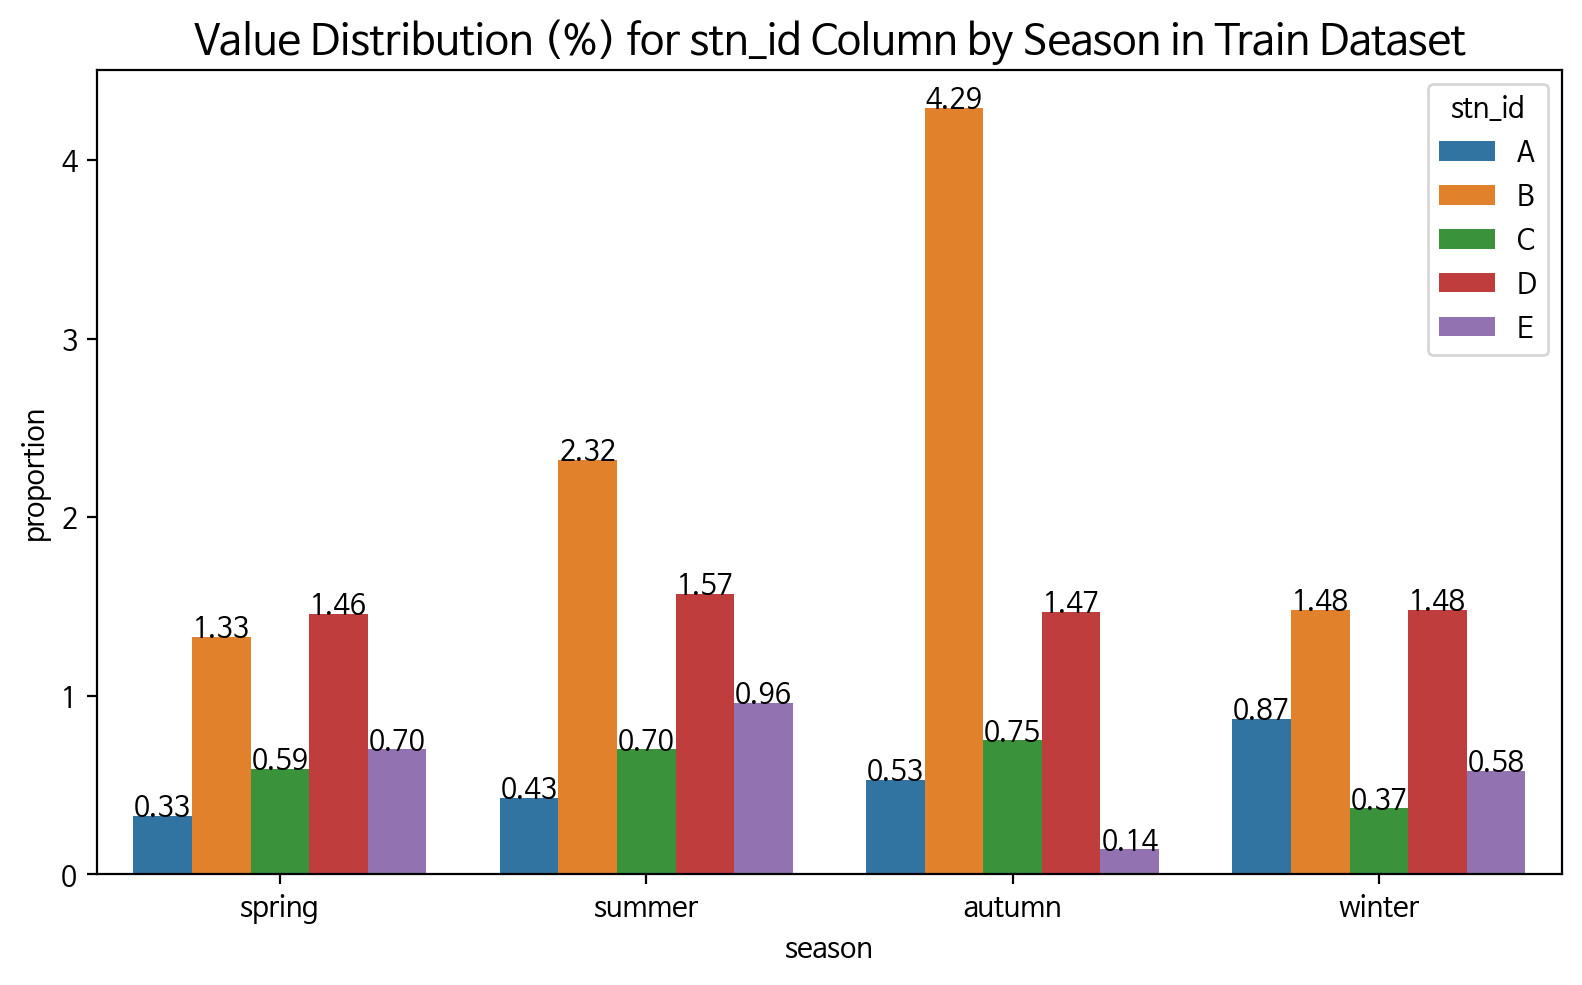

In [63]:
# 결측치 비율 시각화
plt.figure(figsize=(8, 5))

sns_pct = sns.barplot(x="season", 
                      y="proportion", 
                      hue="stn_id", 
                      data=is_fog_df)
                    #   data=np.round(is_fog_df * 100, 2).sort_values(["stn_id", "proportion"], ascending=[True, False]))


# sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                      # bar의 높이를 가져옴
    if height > 0:                                 # 높이가 0보다 클 때만 텍스트를 추가
        plt.text(bar.get_x() + bar.get_width()/2,  # 글자 위치 x좌표
                 height + 0.0005,                   # 글자 위치 y좌표
                 "%.2f" % height,                  # 소수점 셋째 자리까지 비율 표시
                 ha="center")                      # 가운데 정렬


# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Value Distribution (%) for stn_id Column by Season in Train Dataset", fontsize=15)
plt.tight_layout()
plt.show()

#### 3-6-1. 계절별 비교 결과
- 가을, 겨울에 `stn_id` B, D가 많은 비율 차지한다

- 가을, 겨울에 내륙에서 안개가 더 많이 발생한다는 점을 미루어볼 때, B, D는 내륙에 위치할 가능성이 크다

### 3-7. 이슬점 생성 함수

In [119]:
def calculate_dew_point(T, RH):
    # T : 기온, RH : 상대 습도

    b = 17.27
    c = 237.7

    gamma = (b * T) / (c + T) + np.log(RH / 100.0)
    dew_point = (c * gamma) / (b - gamma)

    return dew_point

In [120]:
train_df["dew_point"] = calculate_dew_point(train_df['ta'], train_df['hm'])

#### 3-7-1. 복사안개
- 맑은 날 지표 복사 냉각으로 지표면 온도가 이슬점 온도까지 냉각되어 응결되어 생긴 지표면 안개

- 출처
    - https://m.blog.naver.com/jungjinkim97/221228009422
    - https://blog.naver.com/kma_131/220045985332

#### 3-7-2. 이류안개
- 차가운 수면 위로 따뜻한 공기 (남서풍, 남풍)가 불다가, 그 따뜻한 공기의 온도가 이슬점 온도까지 냉각되어 포화될 때 생기는 연안 안개 및 바다 안개 (해무)

In [22]:
def advection_fog(df, ts, dew_point):
    # 기온 - 이슬점 <= 0, 이슬점 온도보다 기온이 낮다는 뜻
    df["dew_reached"] = df.apply(lambda x: 1 if (x[ts] - x[dew_point] <= 0) else 0, axis=1)

    return df       

In [23]:
train_df = advection_fog(train_df, "ts", "dew_point")

In [24]:
train_df["dew_reached"].value_counts()

dew_reached
0    2903965
1      90885
Name: count, dtype: int64

In [25]:
train_copy = train_df.copy()

In [26]:
train_copy

year  month  day  time  minute stn_id  ws10_deg  ws10_ms      ta  \
0          I      1    1     0      10     AA    0.0000   0.0000 -6.4000   
1          I      1    1     0      20     AA    0.0000   0.0000 -6.3000   
2          I      1    1     0      30     AA    0.0000   0.0000 -6.3000   
3          I      1    1     0      40     AA   27.8000   0.4000 -6.2000   
4          I      1    1     0      50     AA   59.7000   0.5000 -6.1000   
...      ...    ...  ...   ...     ...    ...       ...      ...     ...   
3156454    K     12   31    23      10     EC  305.3000   7.7000  2.5000   
3156455    K     12   31    23      20     EC  293.8000   5.7000  2.3000   
3156456    K     12   31    23      30     EC  274.2000   4.9000  2.2000   
3156457    K     12   31    23      40     EC  270.3000   4.6000  2.1000   
3156458    K     12   31    23      50     EC  254.8000   4.1000  2.1000   

            re      hm  sun10      ts       vis1 class ws10_dir  dew_point  \
0       0.0000 38.9000 0.0000 -2.8000 20000.0000     4        N   -18.0835   
1       0.0000 37.9000 0.0000 -2.7000 20000.0000     4        N   -18.2991   
2       0.0000 40.0000 0.0000 -2.6000 20000.0000     4        N   -17.6649   
3       0.0000 39.5000 0.0000 -2.6000 20000.0000     4      NNE   -17.7229   
4       0.0000 39.8000 0.0000 -2.5000 20000.0000     4       NE   -17.5433   
...        ...     ...    ...     ...        ...   ...      ...        ...   
3156454 0.0000 50.2000 0.0000 -0.9000 20000.0000     4      WNW    -6.8105   
3156455 0.0000 50.1000 0.0000 -1.3000 20000.0000     4      WNW    -7.0211   
3156456 0.0000 51.0000 0.0000 -1.4000 20000.0000     4        W    -6.8827   
3156457 0.0000 51.7000 0.0000 -1.6000 20000.0000     4        W    -6.7983   
3156458 0.0000 53.3000 0.0000 -1.7000 20000.0000     4      WSW    -6.4018   

         dew_reached  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3156454            0  
3156455            0  
3156456            0  
3156457            0  
3156458            0  

[2994850 rows x 18 columns]

In [27]:
# stn_id 수정 : A, B, C, D, E로 수정
train_copy["stn_id"] = train_copy["stn_id"].apply(lambda x: x[0])

In [104]:
# 남서풍, 남풍이 불어올 때 이슬점보다 기온이 내려갔다면 해무가 생성
# 이 때, 이슬점보다 기온이 내려간 것이 관측된 관측소가 해안가쪽 관측소

In [101]:
south_query = "ws10_dir in ['S', 'SSW', 'SW']"
south_train = train_copy.query(south_query)

In [114]:
south_grouped = south_train.groupby(["ws10_dir", "stn_id"]).filter(lambda x: x["dew_reached"].sum() > 0)
# south_grouped = south_train.groupby(["ws10_dir", "stn_id"])
south_grouped.head(3)

year  month  day  time  minute stn_id  ws10_deg  ws10_ms     ta     re  \
218    I      1    2    12      30      A  200.1000   1.3000 3.0000 0.0000   
219    I      1    2    12      40      A  198.3000   1.0000 3.2000 0.0000   
220    I      1    2    12      50      A  197.1000   1.4000 3.2000 0.0000   

         hm  sun10     ts      vis1 class ws10_dir  dew_point  dew_reached  
218 56.6000 0.1100 1.6000 7547.0000     4        S    -4.7734            0  
219 56.0000 0.1200 1.7000 7423.0000     4        S    -4.7271            0  
220 56.7000 0.1100 1.7000 7796.0000     4        S    -4.5627            0

In [123]:
np.sum(south_grouped.groupby(["ws10_dir", "stn_id"])[["dew_reached"]].sum().query(south_query)["dew_reached"])

17774

In [126]:
south_grouped.groupby(["ws10_dir", "stn_id", "class"]).count().query(south_query)[["dew_reached"]]

dew_reached
ws10_dir stn_id class             
S        A      1               40
                2               62
                3              155
                4            52547
         B      1              119
                2              280
                3               94
                4             8315
         C      1               15
                2               32
                3               24
                4            10521
         D      1               72
                2              100
                3              144
                4            29083
         E      1               56
                2               55
                3               78
                4            28888
SSW      A      1               34
                2               73
                3              234
                4            71666
         B      1               93
                2              209
                3               90
                4             9806
         C      1               50
                2               99
                3               67
                4            44295
         D      1              195
                2              241
                3              331
                4            27889
         E      1              169
                2              114
                3              142
                4            34025
SW       A      1               49
                2               86
                3              227
                4            84926
         B      1               90
                2              180
                3              132
                4            23925
         C      1              147
                2              177
                3              131
                4            77012
         D      1              212
                2              275
                3              267
                4            26267
         E      1               60
                2               50
                3               53
                4            26635

In [35]:
train_df.head(3)

year  month  day  time  minute stn_id  ws10_deg  ws10_ms      ta     re  \
0    I      1    1     0      10     AA    0.0000   0.0000 -6.4000 0.0000   
1    I      1    1     0      20     AA    0.0000   0.0000 -6.3000 0.0000   
2    I      1    1     0      30     AA    0.0000   0.0000 -6.3000 0.0000   

       hm  sun10      ts       vis1 class ws10_dir  dew_point  dew_reached  
0 38.9000 0.0000 -2.8000 20000.0000     4        N   -18.0835            0  
1 37.9000 0.0000 -2.7000 20000.0000     4        N   -18.2991            0  
2 40.0000 0.0000 -2.6000 20000.0000     4        N   -17.6649            0

In [38]:
test_df.head(3)

year  month  day  time  minute stn_id  ws10_deg  ws10_ms      ta     re  \
0    L      1    1     0       0     AI  329.5000   0.6000 -2.5000 0.0000   
1    L      1    1     0      10     AI  321.8000   1.2000 -2.5000 0.0000   
2    L      1    1     0      20     AI    0.4000   0.4000 -2.5000 0.0000   

       hm  sun10      ts  class  
0 87.5000 0.0000 -1.6000    NaN  
1 88.2000 0.0000 -1.6000    NaN  
2 88.6000 0.0000 -1.7000    NaN

## 4. EDA

### 4-1. describe()

In [14]:
train_df.describe()

ws10_deg      ws10_ms           ta           re           hm  \
count 2994850.0000 2994850.0000 2994850.0000 2994850.0000 2994850.0000   
mean      184.9465       2.1877      14.0109       0.0531      67.0740   
std       106.4234       1.7522       9.7479       0.2243      21.0526   
min         0.0000       0.0000     -24.0000       0.0000       0.0000   
25%        84.9000       0.9000       6.2000       0.0000      51.6000   
50%       207.9000       1.8000      14.7000       0.0000      69.1000   
75%       275.9000       3.0000      22.2000       0.0000      85.0000   
max       360.0000      21.6000      37.8000       1.0000     100.0000   

             sun10           ts  
count 2994850.0000 2994850.0000  
mean        0.1048      16.0867  
std         0.1594      12.1082  
min         0.0000      -4.9000  
25%         0.0000       5.9000  
50%         0.0100      16.3000  
75%         0.1700      24.6000  
max        26.8700      70.1000

### 4-2. histplot

#### 4-2-1. 수치형 변수

In [16]:
num_cols = train_df.select_dtypes(include=np.number).columns
len(num_cols)

7

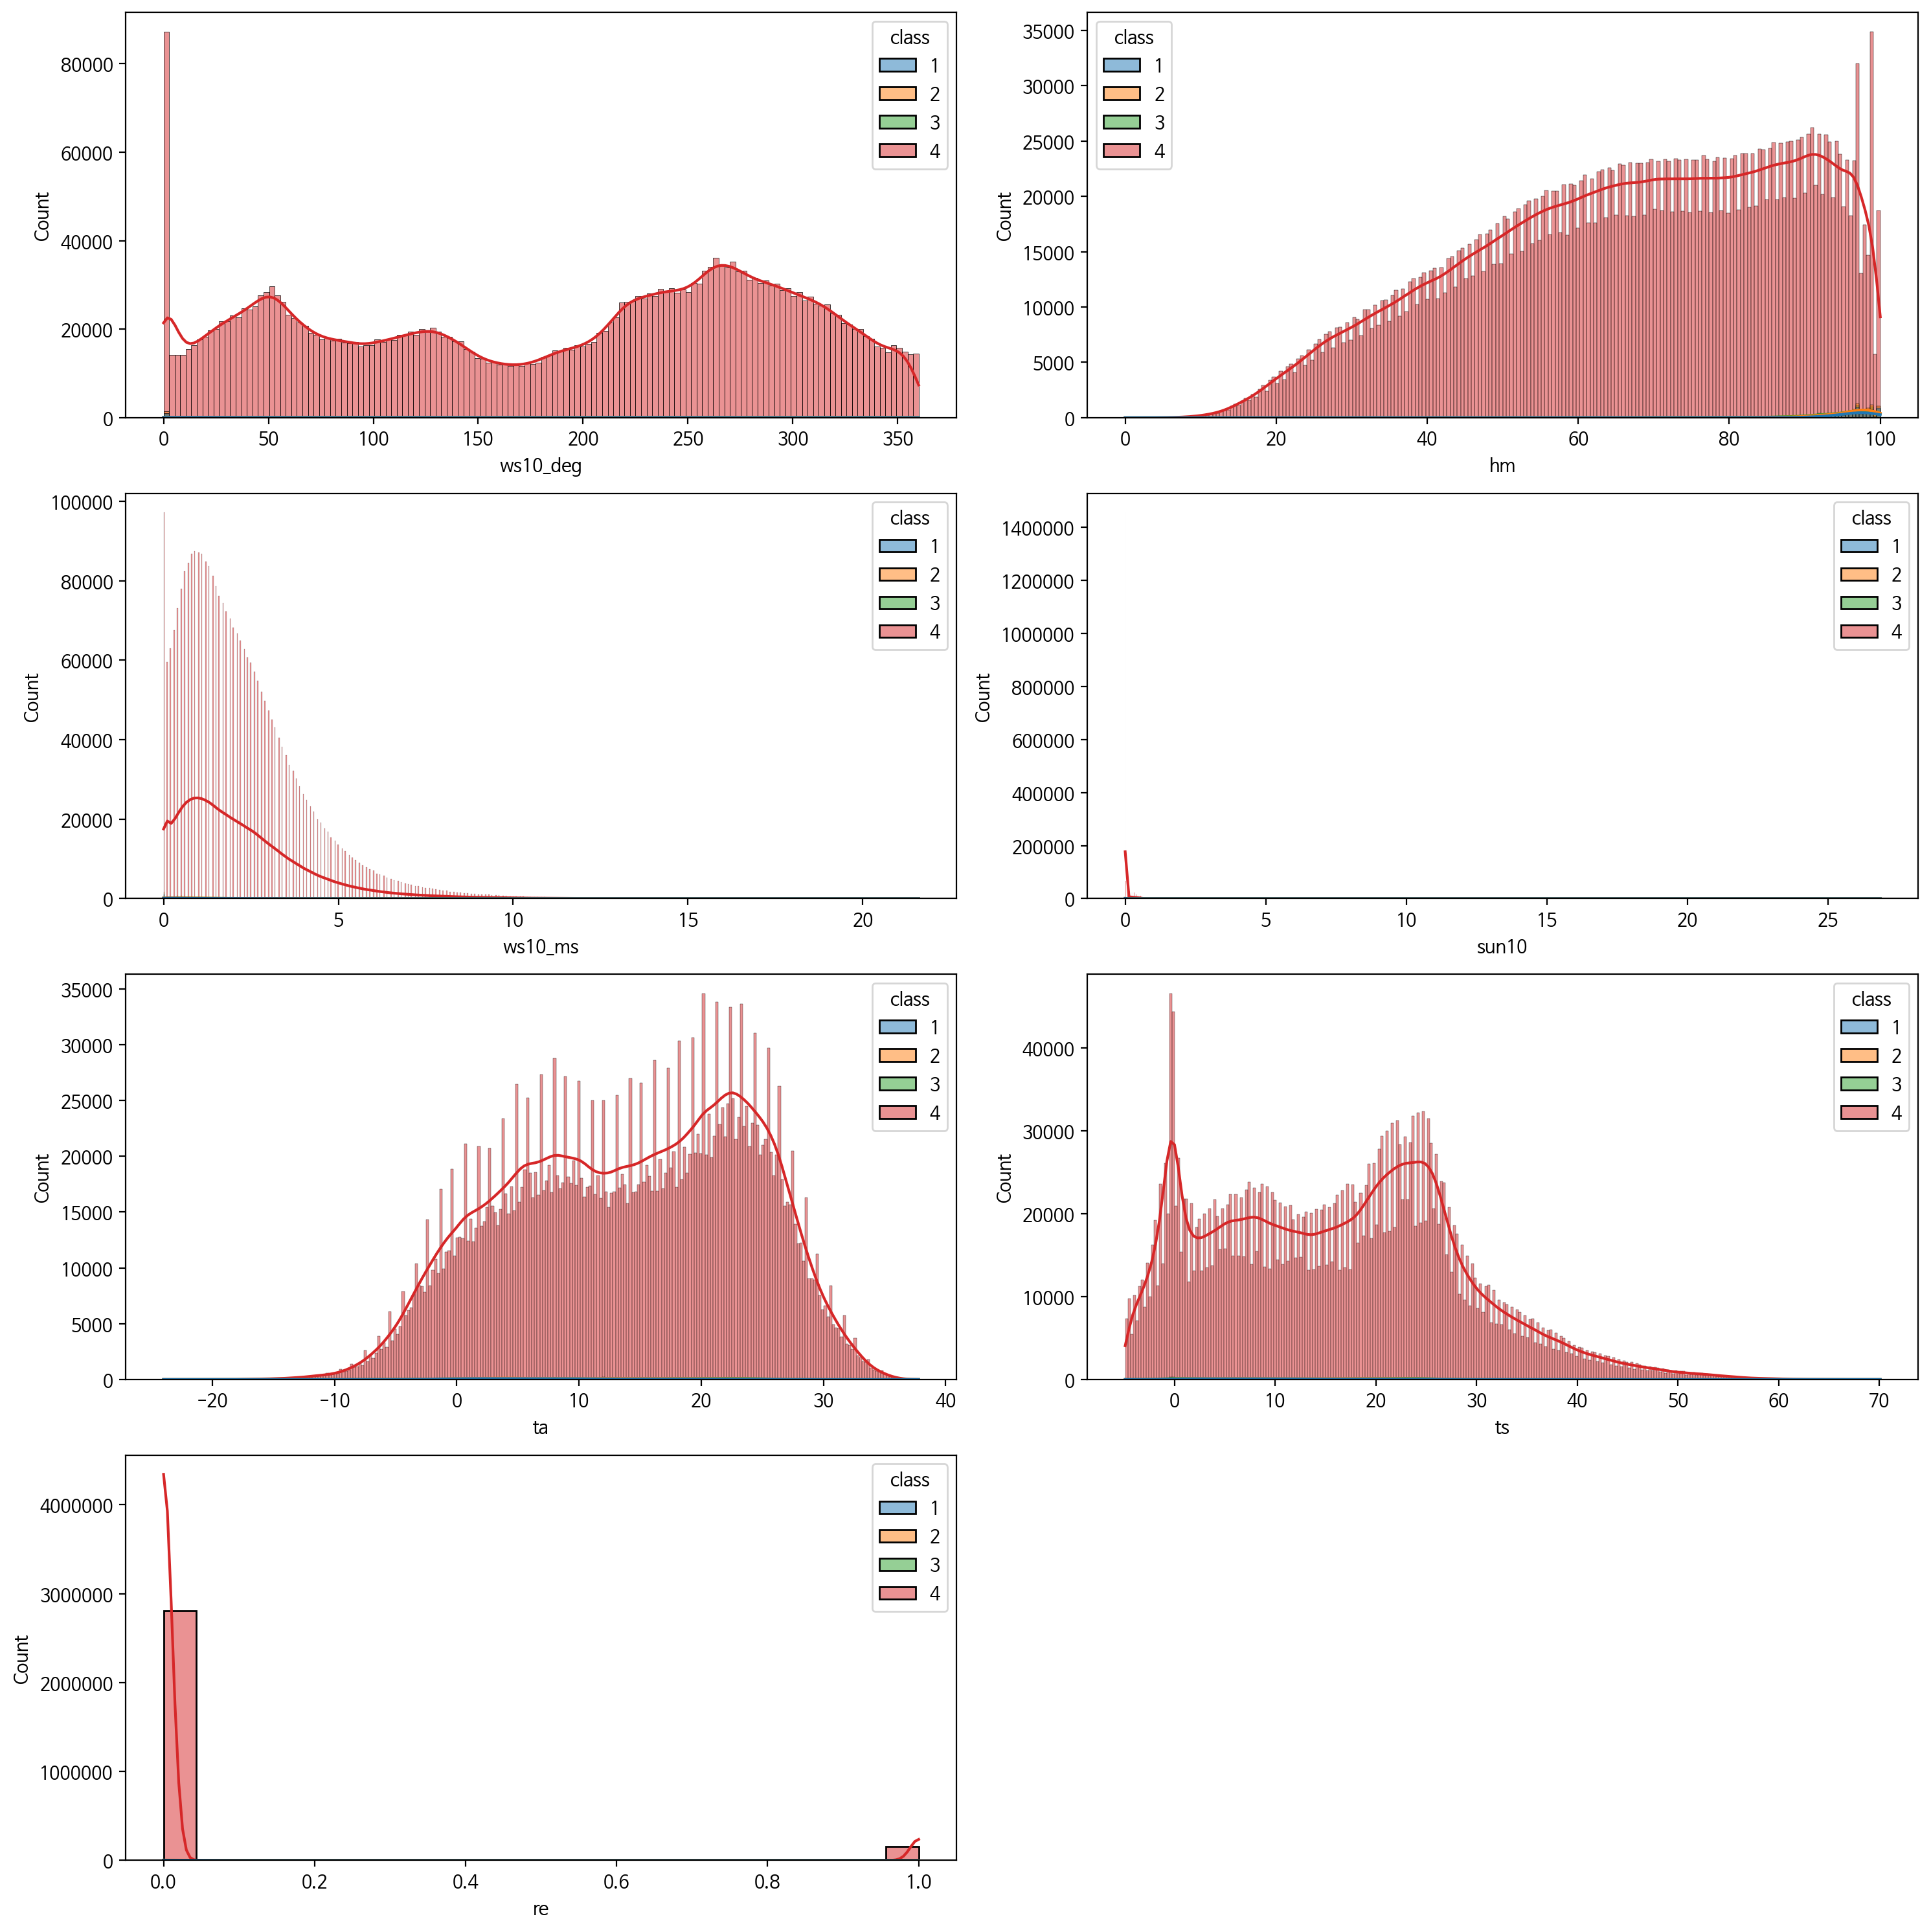

In [16]:
# subplot 생성
nrows, ncols = 4, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))

# flatten()을 통해axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()
hue_order = ["1", "2", "3", "4"]

for col, ax in zip(train_df.select_dtypes(include=np.number).columns, axes):
    sns.histplot(data=train_df, x=col, ax=ax, kde=True, hue="class", hue_order=hue_order)
    # y축 숫자표기 과학적 표기 해제
    ax.get_yaxis().get_major_formatter().set_scientific(False)

fig.delaxes(axes[-1])
fig.tight_layout()
plt.show()

#### 4-2-2. 문자형 변수

In [17]:
str_cols = train_df.select_dtypes(exclude=np.number).columns
str_cols

Index(['stn_id', 'class'], dtype='object')

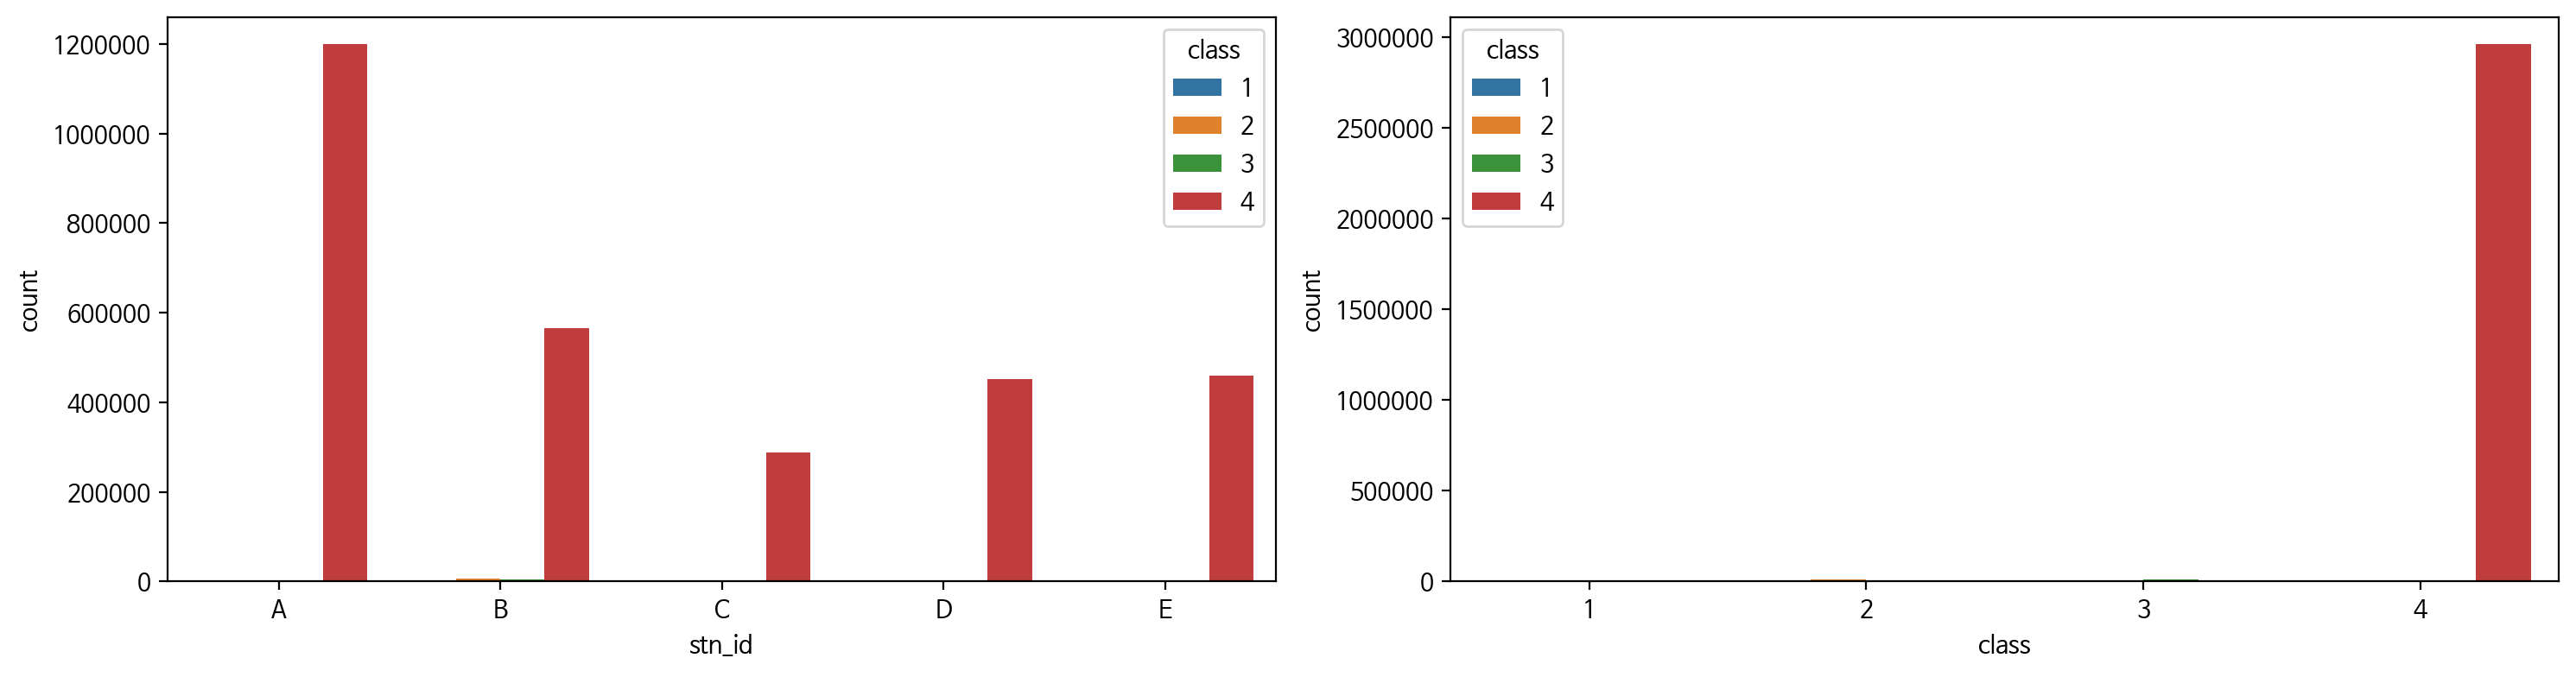

In [18]:
# subplot 생성
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4))

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

for col, ax in zip(str_cols, axes):
    if col=="class":
        sns.countplot(data=train_df, x=col, ax=ax, hue="class",hue_order=hue_order, order=hue_order)
    else:
        sns.countplot(data=train_df, x=col, ax=ax, hue="class",hue_order=hue_order)
    ax.get_yaxis().get_major_formatter().set_scientific(False)

fig.tight_layout()
plt.show()

### 4-3. pairplot

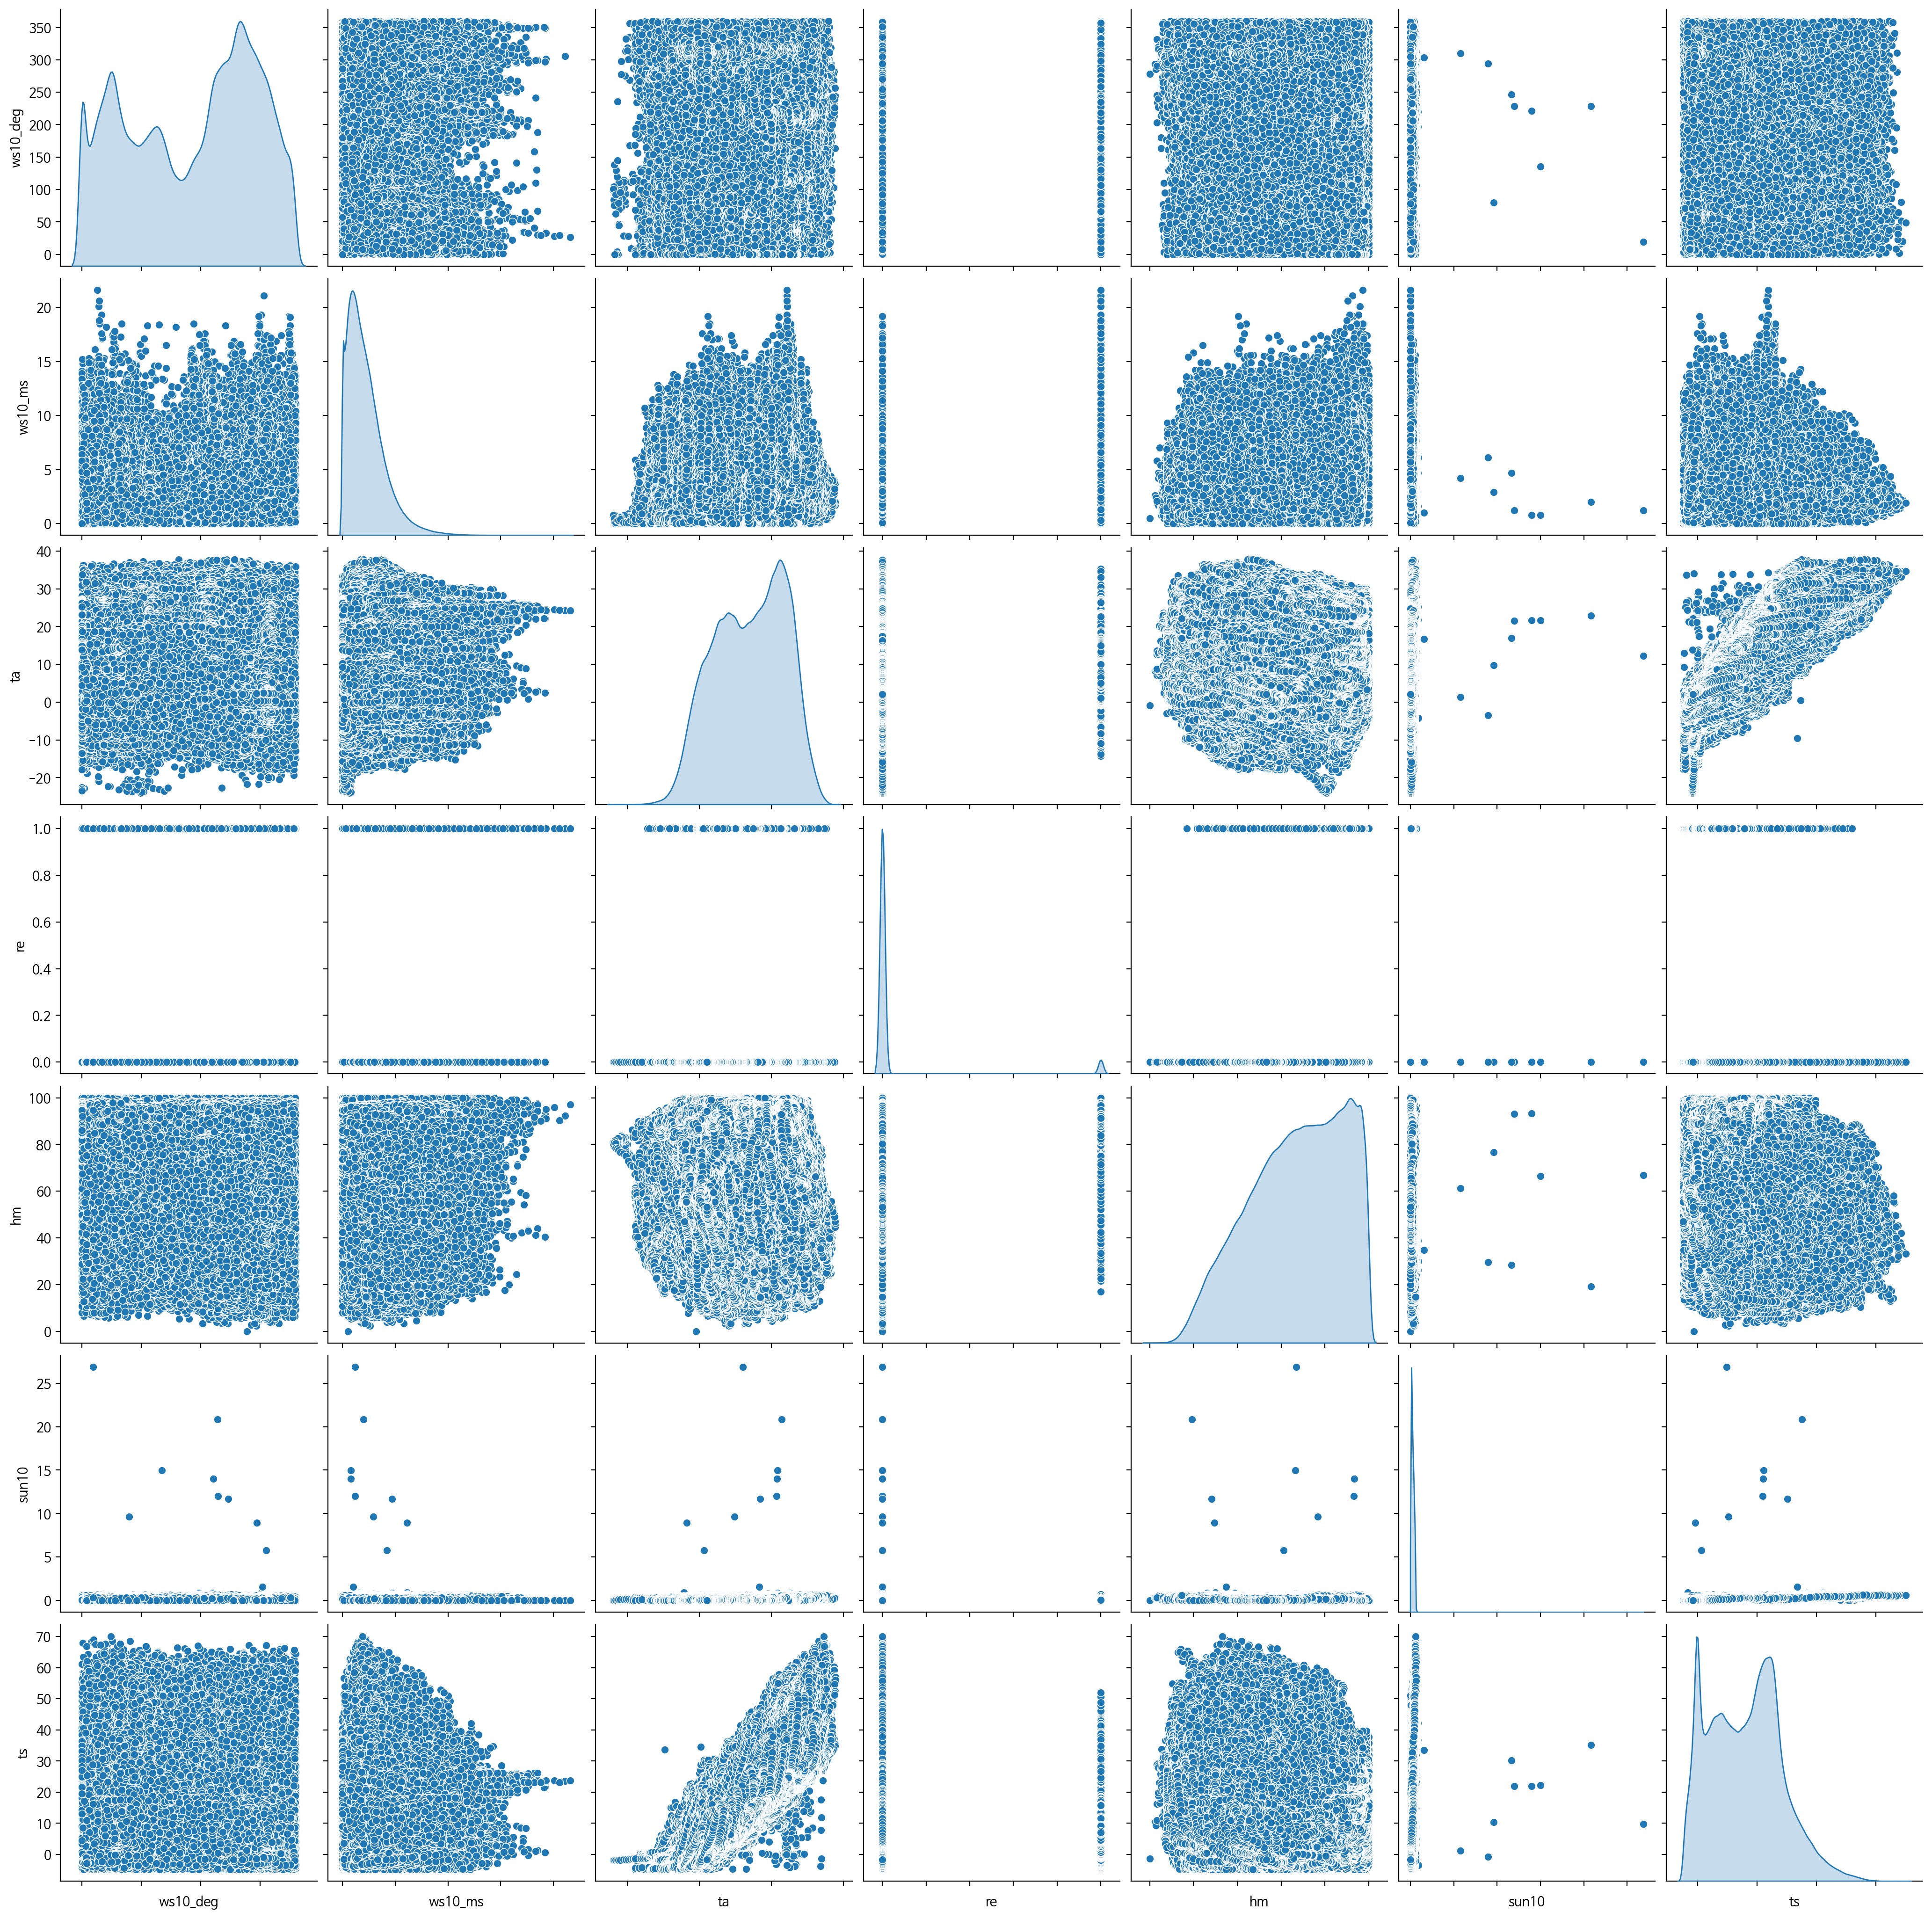

In [19]:
g = sns.pairplot(train_df, palette = 'seismic', diag_kind = 'kde', size=3)
g.set(xticklabels=[])

### 4-4. 상관관계 확인

In [17]:
train_df_corr = train_df[num_cols].corr()

train_df_corr.style.background_gradient()

<Axes: >

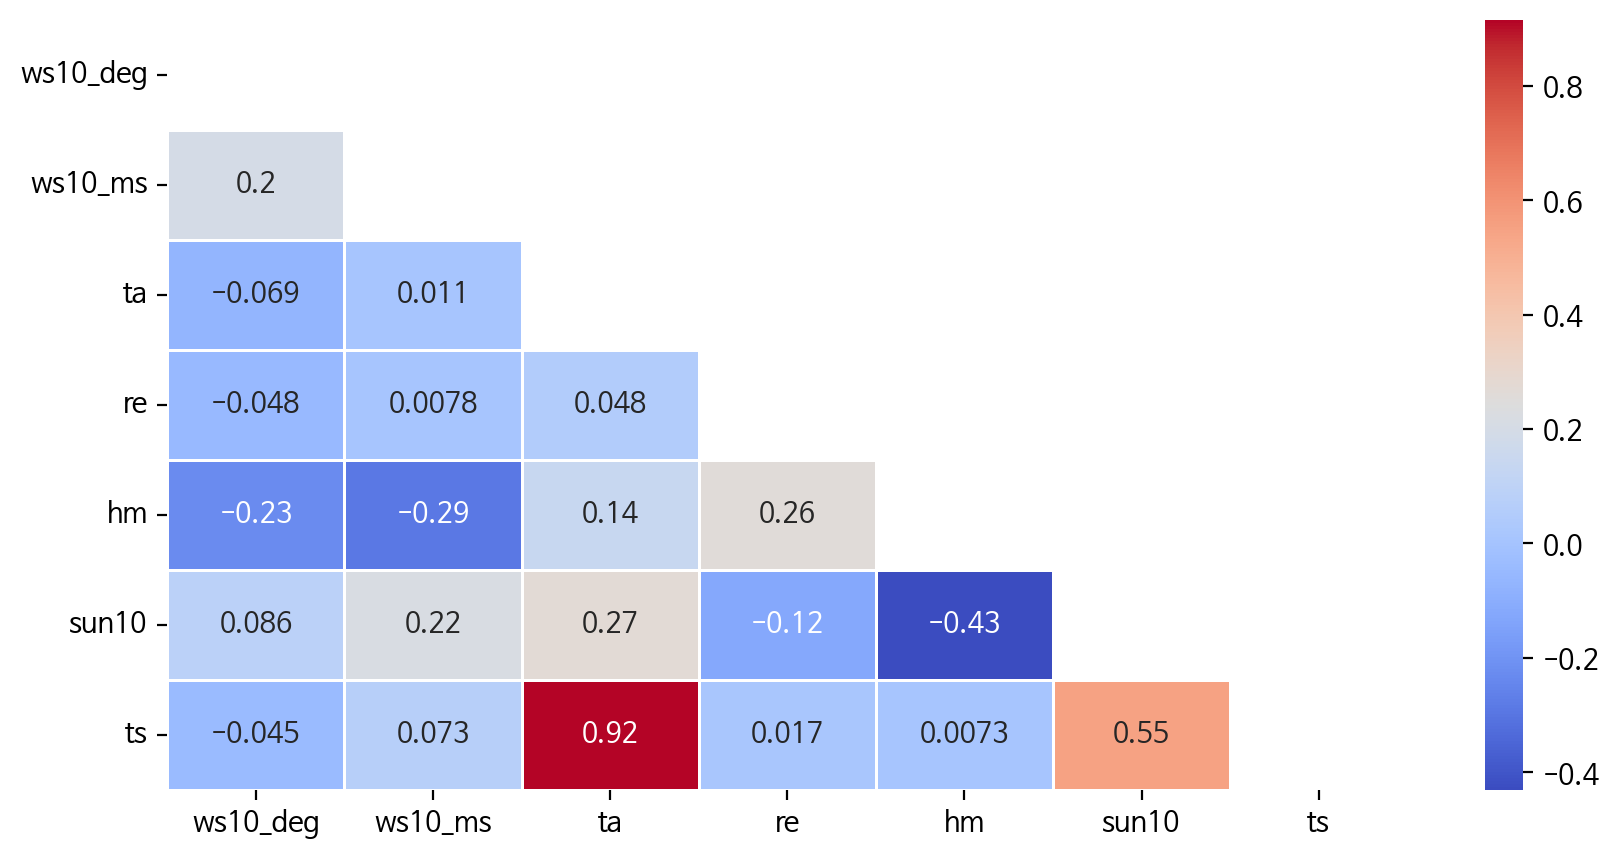

In [18]:
plt.figure(figsize=(10,5))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(train_df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train_df_corr,
            annot=True,         # 실제 값을 표시한다
            mask=mask,          # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,      # 경계면 실선으로 구분하기
            cmap='coolwarm')

### 4-4-1. 상관관계 결과
- 강한 양적 선형관계 (0.7 ~ 1.0)
    - `ta` - `ts` : 평균 기온 - 평균 지면온도
- 뚜렷한 양적 선형관계 (0.3 ~ 0.7)
    - `sun10` - `ts` : 일사량 - 평균 지면 온도
- 약한 양적 선형관계 (0.1 ~ 0.3)
    - `re` - `hm` : 강수 유무 - 평균 상대 습도
    - `ta` - `sum10` : 평균 기온 - 일사량
    - `ws10_ms` - `sun10` : 평균 풍속 - 일사량
- 약한 음적 선형관계 (-0.3 ~ -0.1)
    - `re` - `sun10` : 강수 유무 - 일사량
    - `ws10_deg` - `hm` : 평균 풍향 - 상대 습도
    - `ws10_ms` - `hm` : 평균 풍속 - 상대 습도
- 뚜렷한 음적 선형관계 (-0.7 ~ -0.3)
    - `hm` - `sum10` : 상대 습도 - 일사량

#### 4-4-2. 상관관계 높은 변수 분포 확인
- 상관관계 높은 변수 3가지만 뽑아 관계 시각화
    - 강한 양적 선형관계 (0.7 ~ 1.0)
        - `ta` - `ts` : 평균 기온 - 평균 지면온도
    - 뚜렷한 양적 선형관계 (0.3 ~ 0.7)
        - `sun10` - `ts` : 일사량 - 평균 지면 온도
    - 뚜렷한 음적 선형관계 (-0.7 ~ -0.3)
        - `hm` - `sum10` : 상대 습도 - 일사량

In [19]:
# 상관관계 높은 변수들끼리 짝지워 high_corr에 선언
high_corr = {"ta" : "ts",
             "sun10" : "ts",
             "hm" : "sun10"}
high_corr

{'ta': 'ts', 'sun10': 'ts', 'hm': 'sun10'}

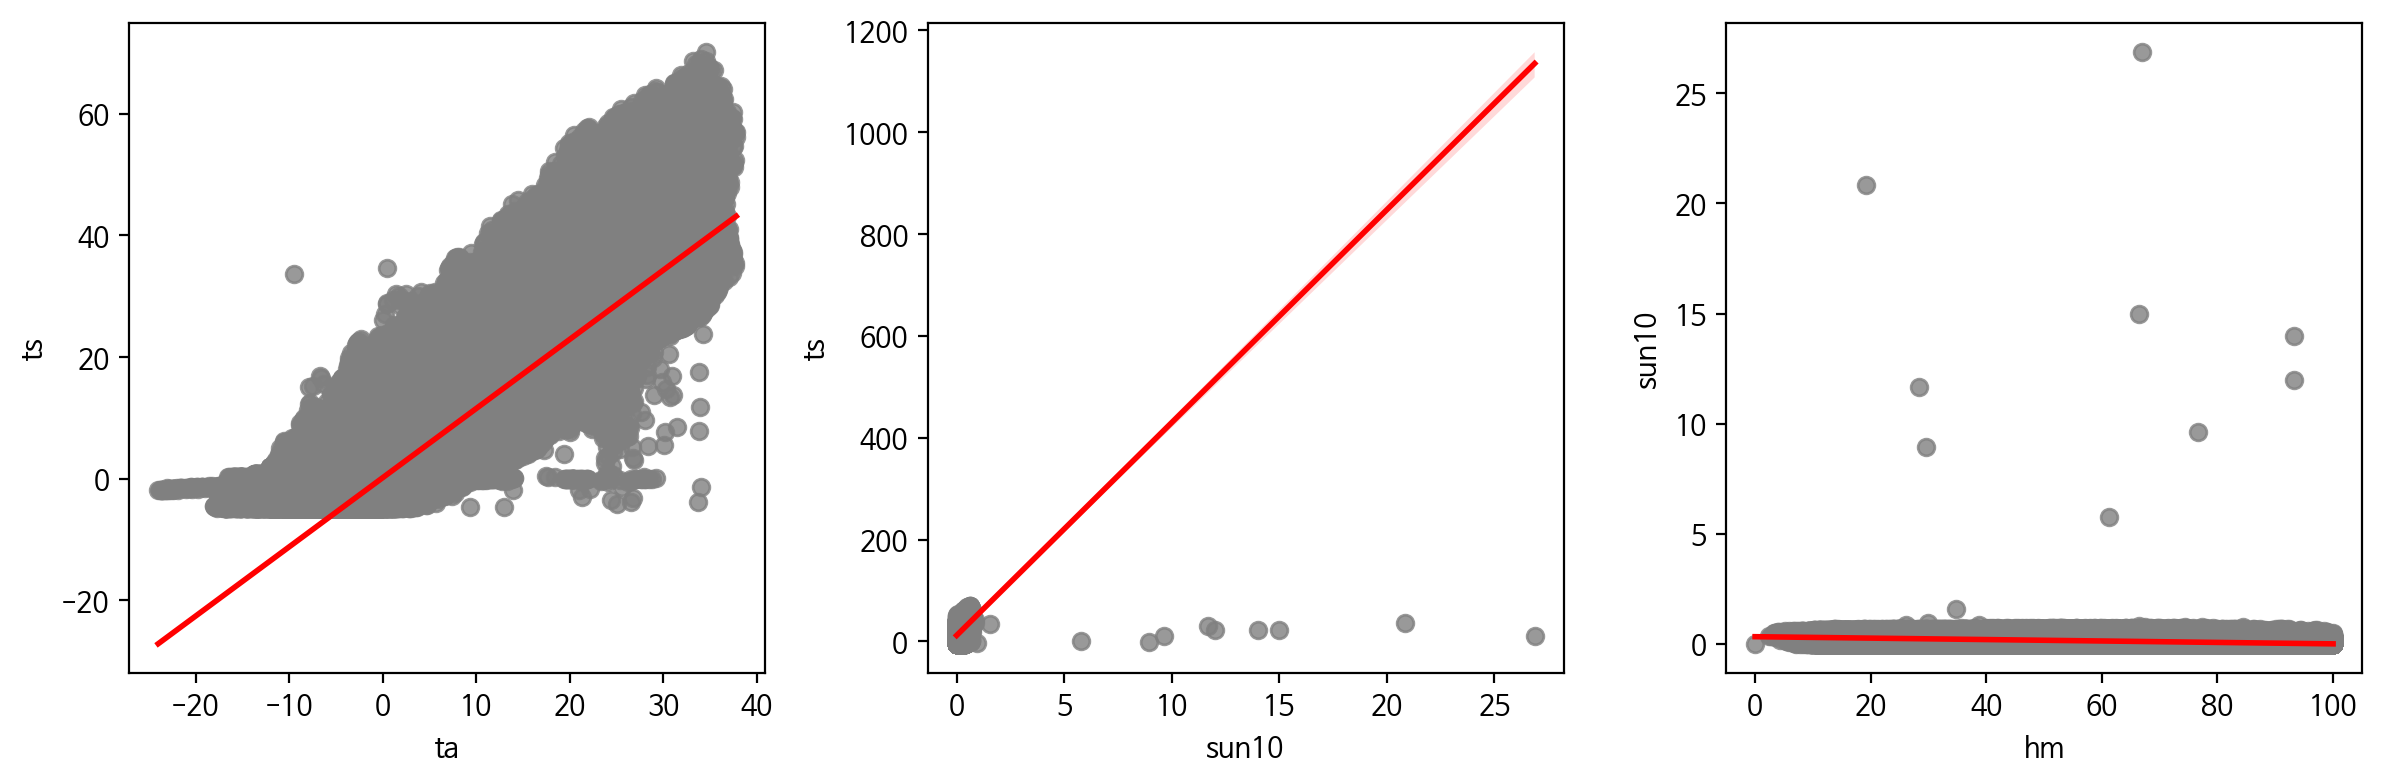

In [20]:
# 상관관계 분포 시각화
# subplot 생성
nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4))

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

# regplot 그려서 추세선과 상관관계 확인
for key, ax in zip(high_corr, axes):
    sns.regplot(x=train_df[f"{key}"],
                y=train_df[high_corr[f"{key}"]],
                ax=ax,
                scatter_kws={"color":"gray"},
                line_kws={"color":"red", "lw":2})

fig.tight_layout()
plt.show()

풍향을 동서남북?
풍향 0, 360 같은각도 아니다
풍향계 따라서는 풍속 충분하지 않아서 판단 힘들면 0으로 표시, 
0~360이 풍향계 따라 동서남북 무관하게 최초 위치를 갖고 360으로 볼 수도 있음
이렇게 디테일한 부분은 기상청에 수집하는 측에 확인해야해서 멘토링에 물어봐

북동 북서 남동 남서 8방향?
안개가 보통 밤~새벽 많이 생성

전처리에 넣을것
- 순서형변수
- vis1 컬럼 사용 (가시거리 평균보려고 했음)
- diff (지표면온도, 평균기온의 차이)
- dew_point